In [13]:
import asyncio
import pandas as pd
import json
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.ticker as mtick
import numpy as np
from gql import Client, gql
from gql.transport.aiohttp import AIOHTTPTransport
import datetime
from datetime import timedelta
import time
%matplotlib inline
plt.style.use('seaborn-whitegrid')

# main asynchronous subgraph call - get data
async def main(chain,token,dateCursor):
    graph_url = f"https://api.thegraph.com/subgraphs/name/shantanu-bico/hyphenv2-liquidity-pool-{chain}"
    transport = AIOHTTPTransport(url=graph_url)

    # Using `async with` on the client will start a connection on the transport
    # and provide a `session` variable to execute queries on this connection
    async with Client(
        transport=transport,
        fetch_schema_from_transport=True,
    ) as session:

        # Execute single query
        query_script = '''
            query tokenPriceInLPSharesLogs {{
                tokenPriceInLPSharesLogs(where:{{tokenAddress:"{tokenAddress}", timestamp_lt: {dateCursor}}}, orderBy: timestamp, orderDirection: desc, first:1000){{
                    tokenAddress
                    timestamp
                    tokenPriceInLPShares
                }}
            }}
        '''.format(tokenAddress = token, dateCursor = dateCursor)
        query = gql(query_script)

        result = await session.execute(query)
        return result

# call subgraph to get min date
async def mindDate(chain,token):
    graph_url = f"https://api.thegraph.com/subgraphs/name/shantanu-bico/hyphenv2-liquidity-pool-{chain}"
    transport = AIOHTTPTransport(url=graph_url)

    # Using `async with` on the client will start a connection on the transport
    # and provide a `session` variable to execute queries on this connection
    async with Client(
        transport=transport,
        fetch_schema_from_transport=True,
    ) as session:

        # Execute single query
        query_script = '''
            query tokenPriceInLPSharesLogs {{
                tokenPriceInLPSharesLogs(where:{{tokenAddress:"{tokenAddress}"}}, orderBy: timestamp, orderDirection: asc, first:1){{
                    tokenAddress
                    timestamp
                    tokenPriceInLPShares
                }}
            }}
        '''.format(tokenAddress = token)
        query = gql(query_script)

        result = await session.execute(query)
        return result

In [14]:
# build list of hyphen chains
hyphen_chains = ["ethereum", "polygon", "bsc", "avalanche", "optimism", "arbitrum", "fantom"]

# create token list
token_list = [["ethereum","0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48","USDC","6"],
["ethereum","0xdac17f958d2ee523a2206206994597c13d831ec7","USDT","6"],
["ethereum","0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee","ETH","18"],
["ethereum","0xf17e65822b568b3903685a7c9f496cf7656cc6c2","BICO","18"],
["polygon","0x2791bca1f2de4661ed88a30c99a7a9449aa84174","USDC","6"],
["polygon","0xc2132d05d31c914a87c6611c10748aeb04b58e8f","USDT","6"],
["polygon","0x7ceb23fd6bc0add59e62ac25578270cff1b9f619","ETH","18"],
["polygon","0x91c89a94567980f0e9723b487b0bed586ee96aa7","BICO","18"],
["avalanche","0xa7d7079b0fead91f3e65f86e8915cb59c1a4c664","USDC","6"],
["avalanche","0x49d5c2bdffac6ce2bfdb6640f4f80f226bc10bab","ETH","18"],
["bsc","0x2170Ed0880ac9A755fd29B2688956BD959F933F8","ETH","18"],
["bsc","0x8AC76a51cc950d9822D68b83fE1Ad97B32Cd580d","USDC","18"],
["bsc","0x55d398326f99059fF775485246999027B3197955","USDT","18"],
["bsc","0x06250a4962558f0f3e69fc07f4c67bb9c9eac739","BICO","18"],
["optimism","0x7F5c764cBc14f9669B88837ca1490cCa17c31607","USDC","6"],
["optimism","0xEeeeeEeeeEeEeeEeEeEeeEEEeeeeEeeeeeeeEEeE","ETH","18"],
["optimism","0xd6909e9e702024eb93312B989ee46794c0fB1C9D","BICO","18"],
["arbitrum","0xFF970A61A04b1cA14834A43f5dE4533eBDDB5CC8","USDC","6"],
["arbitrum","0xa68Ec98D7ca870cF1Dd0b00EBbb7c4bF60A8e74d","BICO","18"],
["arbitrum","0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee","ETH","18"],
["fantom","0x524CAbe5b2F66CBd6F6b08dEf086F18F8DdE033a","BICO","18"],
["fantom","0x04068da6c83afcfa0e13ba15a6696662335d5b75","USDC","18"]]

df_tokens = pd.DataFrame(token_list, columns=["chain","tokenAddress","tokenSymbol","decimalPlaces"])

# make tokenAddress lowercase
df_tokens["tokenAddress"] = df_tokens["tokenAddress"].str.lower()
# make decimalPlaces int
df_tokens["decimalPlaces"] = pd.to_numeric(df_tokens["decimalPlaces"]).astype(int)

In [15]:
# loop through each chain and token to get last 1000 records
# Execute the query on the transport

########################################################################################################### first build a table of min dates across all pools
async def getMinDates(thisChain, pool):
    result_json_min_date = await mindDate(thisChain, pool)
    return result_json_min_date["tokenPriceInLPSharesLogs"]

return_list_min_dates = []
for row in df_tokens.iterrows():
    this_list = await getMinDates(row[1].chain, row[1].tokenAddress)
    # add chain using list comprehension
    this_list = [dict(item, **{'chain':row[1].chain}) for item in this_list]
    return_list_min_dates.append(this_list)

# truncate list into one list for transform to df
master_list_min_dates = []
for i in range(len(token_list)):
    for x in return_list_min_dates[i]:
        master_list_min_dates.append(x)

# convert json (in list) to df
df_lp_token_min_dates = pd.read_json(json.dumps(master_list_min_dates))

########################################################################################################### now get liquidity
async def appendList(thisChain, pool, dateCursor):
    result_json = await main(thisChain, pool, dateCursor)
    return result_json["tokenPriceInLPSharesLogs"]

# create debug list
debug_list_lp_token = []

# call async func from basic for loop
return_list = []
print('####################################################################################### starting LP token data build:')
for row in df_tokens.iterrows():
    # get start time so we can report to user
    start_time = time.time()
    # get today + 1 unix timestamp for query start
    ms = datetime.datetime.now() + datetime.timedelta(days=1)
    dateCursor = (pd.to_datetime(ms) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    # get chain min date and convert to unix
    pool_min_date = (df_lp_token_min_dates['timestamp'][(df_lp_token_min_dates['chain']==row[1].chain)&(df_lp_token_min_dates['tokenAddress']==row[1].tokenAddress)].iloc[0] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    # loop until we reach min date for this pool
    l = 0
    while dateCursor > pool_min_date:
        debug_item = {"loop": l, "chain": row[1].chain, "pool": row[1].tokenSymbol, "start_date": dateCursor, "min_date": pool_min_date}
        debug_list_lp_token.append(debug_item)
        this_list = await appendList(row[1].chain, row[1].tokenAddress, dateCursor)
        # add chain using list comprehension
        this_list = [dict(item, **{'chain':row[1].chain}) for item in this_list]
        # iterate the cursor for this pool
        dateCursor = int(this_list[len(this_list)-1]['timestamp'])
        return_list.append(this_list)
        l = l + 1
    print(f'{row[1].tokenSymbol} on {row[1].chain} get data loops took {time.time() - start_time} seconds')

# truncate list into one list for transform to df    
# first flaten list
return_list = [item for sublist in return_list for item in sublist]
print(f'combined list is {len(return_list)} records')

# convert json (in list) to df
df_lp_token_value = pd.read_json(json.dumps(return_list))

# make tokenAddress lowercase
df_lp_token_value["tokenAddress"] = df_lp_token_value["tokenAddress"].str.lower()
# join in token symbol
df_lp_token_value = pd.merge(df_lp_token_value, df_tokens[['chain','tokenAddress','tokenSymbol','decimalPlaces']], how="left", left_on=["chain","tokenAddress"], right_on=["chain","tokenAddress"])

####################################################################################### starting LP token data build:
USDC on ethereum get data loops took 1.8030238151550293 seconds
USDT on ethereum get data loops took 0.6350960731506348 seconds
ETH on ethereum get data loops took 6.872616767883301 seconds
BICO on ethereum get data loops took 0.5205466747283936 seconds
USDC on polygon get data loops took 28.62428903579712 seconds
USDT on polygon get data loops took 4.492779016494751 seconds
ETH on polygon get data loops took 14.375173091888428 seconds
BICO on polygon get data loops took 0.8557779788970947 seconds
USDC on avalanche get data loops took 3.7793610095977783 seconds
ETH on avalanche get data loops took 2.5242249965667725 seconds
ETH on bsc get data loops took 4.9087700843811035 seconds
USDC on bsc get data loops took 12.142628192901611 seconds
USDT on bsc get data loops took 5.269322872161865 seconds
BICO on bsc get data loops took 0.808478832244873 seconds
USDC on optimism 

In [16]:
# get token values
df_lp_token_value['tokenPriceInLPSharesReadable'] = df_lp_token_value['tokenPriceInLPShares'] / (10**df_lp_token_value['decimalPlaces'])

# create new df with index set as time / group the data and get the last value in a weekly range
df_lp_token_ma = df_lp_token_value.sort_values(by=['chain','tokenSymbol','timestamp'], ascending=False).set_index('timestamp')
df_lp_token_ma.index = pd.to_datetime(df_lp_token_ma.index)
df_lp_token_ma = df_lp_token_ma.groupby(['chain','tokenSymbol',df_lp_token_ma.index.isocalendar().week]).head(1)

# get previous lp token price and date
df_lp_token_ma['prev_wk_lp_token_price'] = df_lp_token_ma.groupby(['chain','tokenSymbol'])['tokenPriceInLPSharesReadable'].shift(-1)
df_lp_token_ma['timestamp_d'] = df_lp_token_ma.index
df_lp_token_ma['prev_wk_end_date'] = df_lp_token_ma.groupby(['chain','tokenSymbol'])['timestamp_d'].shift(-1)
df_lp_token_ma['prev_wk_end_date_hours'] = (df_lp_token_ma.index - df_lp_token_ma['prev_wk_end_date']).astype('timedelta64[h]')
df_lp_token_ma['prev_wk_end_date_days'] = df_lp_token_ma['prev_wk_end_date_hours']/24
df_lp_token_ma['compound_periods'] = 365/df_lp_token_ma['prev_wk_end_date_days']
df_lp_token_ma = df_lp_token_ma.drop(['tokenPriceInLPShares','decimalPlaces','timestamp_d','prev_wk_end_date_hours','prev_wk_end_date_days'], axis=1).reset_index()

# calculate apy
df_lp_token_ma['one_wk_hpy'] = ((df_lp_token_ma['tokenPriceInLPSharesReadable']/df_lp_token_ma['prev_wk_lp_token_price'])-1)*-1
df_lp_token_ma['apy'] = ((1+df_lp_token_ma['one_wk_hpy'])**df_lp_token_ma['compound_periods'])-1

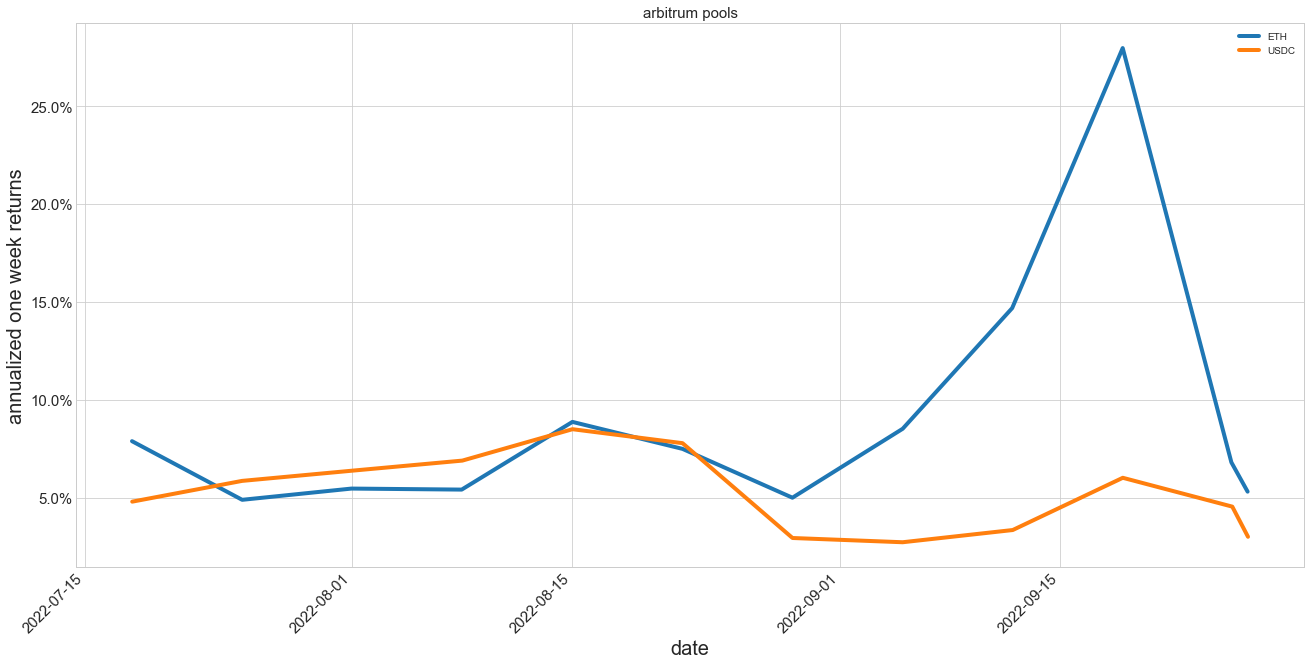

In [24]:
# arbitrum Pools
chart_chain = 'arbitrum'
# basic line chart to see trend of pools
# create series
fig, ax = plt.subplots()
x_eth = df_lp_token_ma['timestamp'][(df_lp_token_ma['chain']==chart_chain)&(df_lp_token_ma['tokenSymbol']=='ETH')]
y_eth = df_lp_token_ma['apy'][(df_lp_token_ma['chain']==chart_chain)&(df_lp_token_ma['tokenSymbol']=='ETH')]
x_usdc = df_lp_token_ma['timestamp'][(df_lp_token_ma['chain']==chart_chain)&(df_lp_token_ma['tokenSymbol']=='USDC')]
y_usdc = df_lp_token_ma['apy'][(df_lp_token_ma['chain']==chart_chain)&(df_lp_token_ma['tokenSymbol']=='USDC')]

# add series
ax.plot(x_eth, y_eth, linewidth=4.0, label="ETH")
ax.plot(x_usdc, y_usdc, linewidth=4.0, label="USDC")

plt.title(f'{chart_chain} pools', loc='center', fontsize=15)
plt.xticks(rotation=45, ha="right", fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('date', fontsize=20)
plt.ylabel('annualized one week returns', fontsize=20)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# width, height
plt.rcParams["figure.figsize"]=(22, 10)
plt.legend(loc='best')

plt.show()

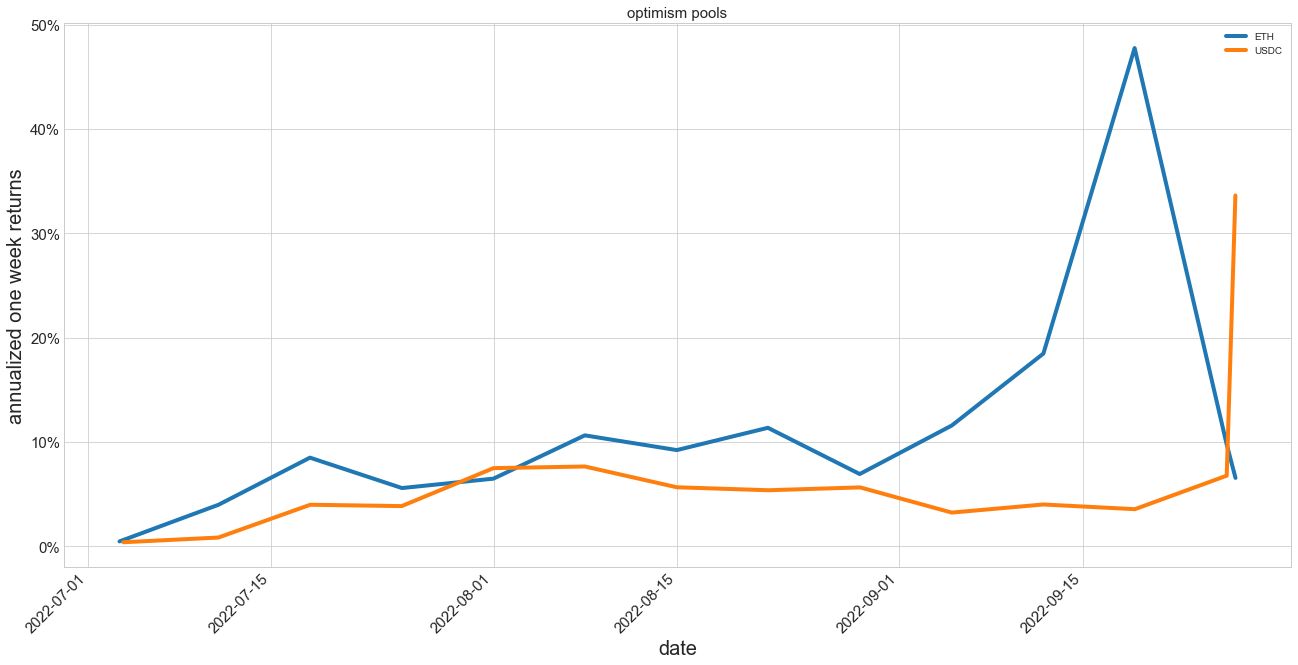

In [18]:
# optimism Pools
chart_chain = 'optimism'
# basic line chart to see trend of pools
# create series
fig, ax = plt.subplots()
x_eth = df_lp_token_ma['timestamp'][(df_lp_token_ma['chain']==chart_chain)&(df_lp_token_ma['tokenSymbol']=='ETH')]
y_eth = df_lp_token_ma['apy'][(df_lp_token_ma['chain']==chart_chain)&(df_lp_token_ma['tokenSymbol']=='ETH')]
x_usdc = df_lp_token_ma['timestamp'][(df_lp_token_ma['chain']==chart_chain)&(df_lp_token_ma['tokenSymbol']=='USDC')]
y_usdc = df_lp_token_ma['apy'][(df_lp_token_ma['chain']==chart_chain)&(df_lp_token_ma['tokenSymbol']=='USDC')]

# add series
ax.plot(x_eth, y_eth, linewidth=4.0, label="ETH")
ax.plot(x_usdc, y_usdc, linewidth=4.0, label="USDC")

plt.title(f'{chart_chain} pools', loc='center', fontsize=15)
plt.xticks(rotation=45, ha="right", fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('date', fontsize=20)
plt.ylabel('annualized one week returns', fontsize=20)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# width, height
plt.rcParams["figure.figsize"]=(22, 10)
plt.legend(loc='best')

plt.show()

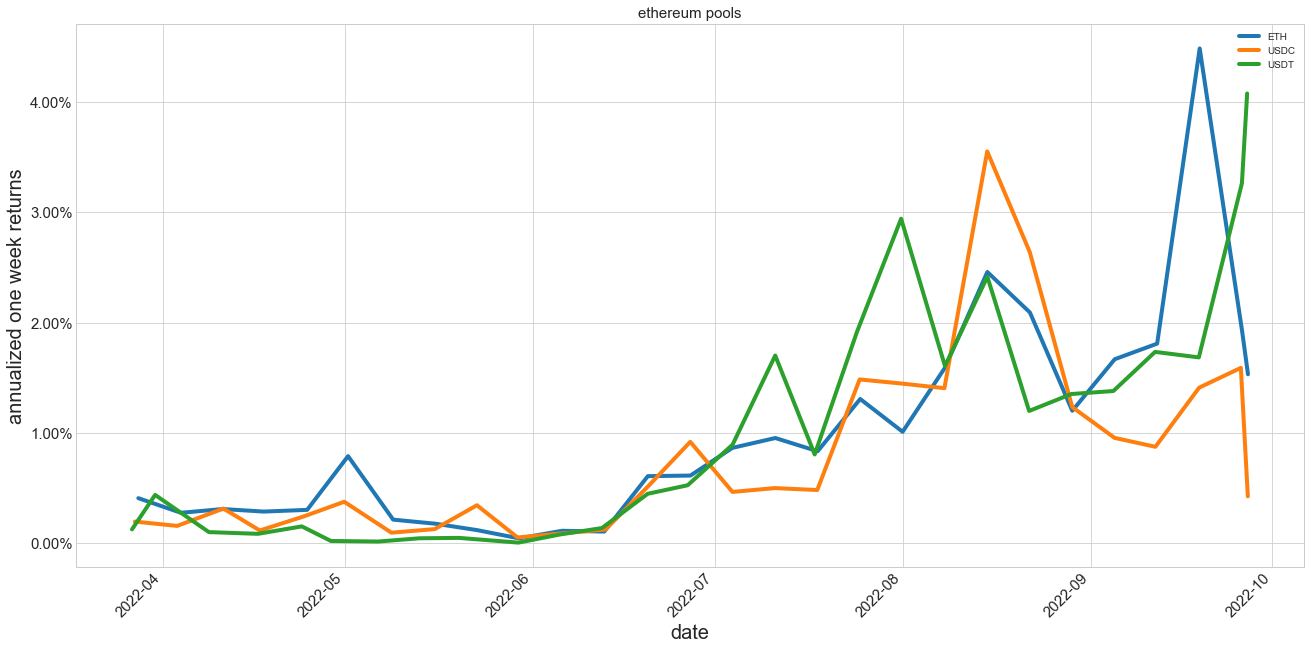

In [19]:
# ethereum Pools
chart_chain = 'ethereum'
# basic line chart to see trend of pools
# create series
fig, ax = plt.subplots()
x_eth = df_lp_token_ma['timestamp'][(df_lp_token_ma['chain']==chart_chain)&(df_lp_token_ma['tokenSymbol']=='ETH')]
y_eth = df_lp_token_ma['apy'][(df_lp_token_ma['chain']==chart_chain)&(df_lp_token_ma['tokenSymbol']=='ETH')]
x_usdc = df_lp_token_ma['timestamp'][(df_lp_token_ma['chain']==chart_chain)&(df_lp_token_ma['tokenSymbol']=='USDC')]
y_usdc = df_lp_token_ma['apy'][(df_lp_token_ma['chain']==chart_chain)&(df_lp_token_ma['tokenSymbol']=='USDC')]
x_usdt = df_lp_token_ma['timestamp'][(df_lp_token_ma['chain']==chart_chain)&(df_lp_token_ma['tokenSymbol']=='USDT')]
y_usdt = df_lp_token_ma['apy'][(df_lp_token_ma['chain']==chart_chain)&(df_lp_token_ma['tokenSymbol']=='USDT')]

# add series
ax.plot(x_eth, y_eth, linewidth=4.0, label="ETH")
ax.plot(x_usdc, y_usdc, linewidth=4.0, label="USDC")
ax.plot(x_usdt, y_usdt, linewidth=4.0, label="USDT")

plt.title(f'{chart_chain} pools', loc='center', fontsize=15)
plt.xticks(rotation=45, ha="right", fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('date', fontsize=20)
plt.ylabel('annualized one week returns', fontsize=20)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# width, height
plt.rcParams["figure.figsize"]=(22, 10)
plt.legend(loc='best')

plt.show()

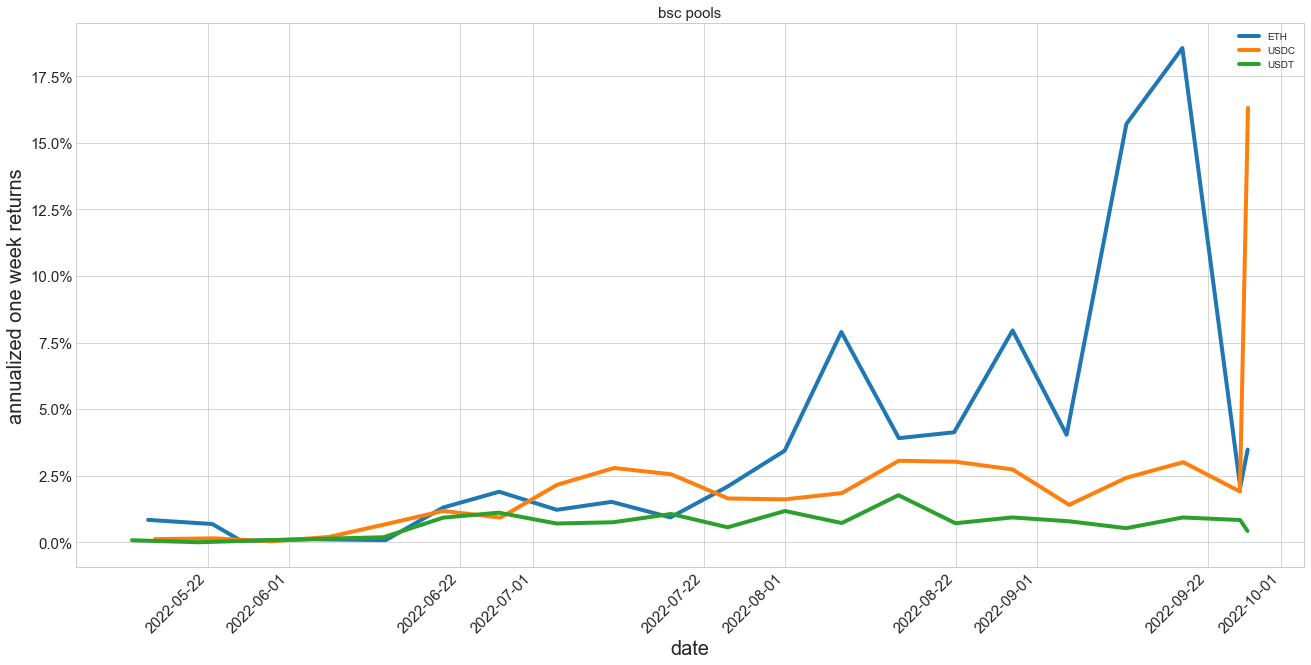

In [20]:
# bsc Pools
chart_chain = 'bsc'
# basic line chart to see trend of pools
# create series
fig, ax = plt.subplots()
x_eth = df_lp_token_ma['timestamp'][(df_lp_token_ma['chain']==chart_chain)&(df_lp_token_ma['tokenSymbol']=='ETH')]
y_eth = df_lp_token_ma['apy'][(df_lp_token_ma['chain']==chart_chain)&(df_lp_token_ma['tokenSymbol']=='ETH')]
x_usdc = df_lp_token_ma['timestamp'][(df_lp_token_ma['chain']==chart_chain)&(df_lp_token_ma['tokenSymbol']=='USDC')]
y_usdc = df_lp_token_ma['apy'][(df_lp_token_ma['chain']==chart_chain)&(df_lp_token_ma['tokenSymbol']=='USDC')]
x_usdt = df_lp_token_ma['timestamp'][(df_lp_token_ma['chain']==chart_chain)&(df_lp_token_ma['tokenSymbol']=='USDT')]
y_usdt = df_lp_token_ma['apy'][(df_lp_token_ma['chain']==chart_chain)&(df_lp_token_ma['tokenSymbol']=='USDT')]

# add series
ax.plot(x_eth, y_eth, linewidth=4.0, label="ETH")
ax.plot(x_usdc, y_usdc, linewidth=4.0, label="USDC")
ax.plot(x_usdt, y_usdt, linewidth=4.0, label="USDT")

plt.title(f'{chart_chain} pools', loc='center', fontsize=15)
plt.xticks(rotation=45, ha="right", fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('date', fontsize=20)
plt.ylabel('annualized one week returns', fontsize=20)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# width, height
plt.rcParams["figure.figsize"]=(22, 10)
plt.legend(loc='best')

plt.show()

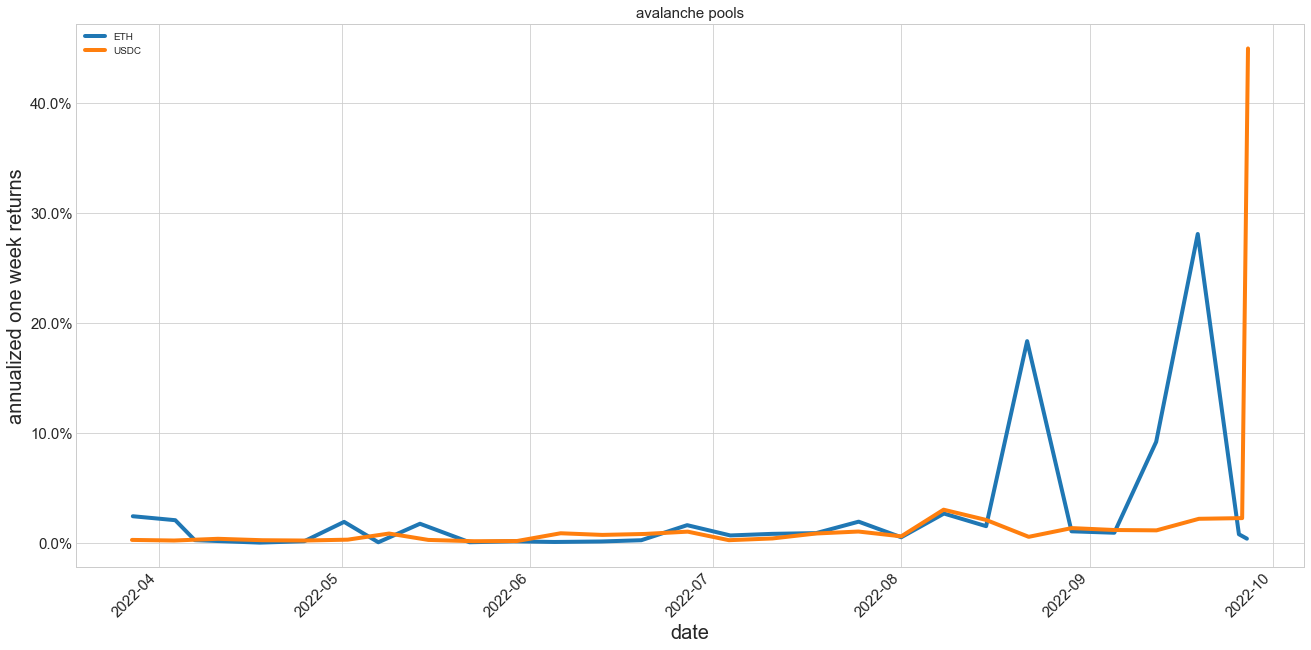

In [21]:
# avalanche Pools
chart_chain = 'avalanche'
# basic line chart to see trend of pools
# create series
fig, ax = plt.subplots()
x_eth = df_lp_token_ma['timestamp'][(df_lp_token_ma['chain']==chart_chain)&(df_lp_token_ma['tokenSymbol']=='ETH')]
y_eth = df_lp_token_ma['apy'][(df_lp_token_ma['chain']==chart_chain)&(df_lp_token_ma['tokenSymbol']=='ETH')]
x_usdc = df_lp_token_ma['timestamp'][(df_lp_token_ma['chain']==chart_chain)&(df_lp_token_ma['tokenSymbol']=='USDC')]
y_usdc = df_lp_token_ma['apy'][(df_lp_token_ma['chain']==chart_chain)&(df_lp_token_ma['tokenSymbol']=='USDC')]
# x_usdt = df_lp_token_ma['timestamp'][(df_lp_token_ma['chain']==chart_chain)&(df_lp_token_ma['tokenSymbol']=='USDT')]
# y_usdt = df_lp_token_ma['apy'][(df_lp_token_ma['chain']==chart_chain)&(df_lp_token_ma['tokenSymbol']=='USDT')]

# add series
ax.plot(x_eth, y_eth, linewidth=4.0, label="ETH")
ax.plot(x_usdc, y_usdc, linewidth=4.0, label="USDC")
# ax.plot(x_usdt, y_usdt, linewidth=4.0, label="USDT")

plt.title(f'{chart_chain} pools', loc='center', fontsize=15)
plt.xticks(rotation=45, ha="right", fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('date', fontsize=20)
plt.ylabel('annualized one week returns', fontsize=20)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# width, height
plt.rcParams["figure.figsize"]=(22, 10)
plt.legend(loc='best')

plt.show()

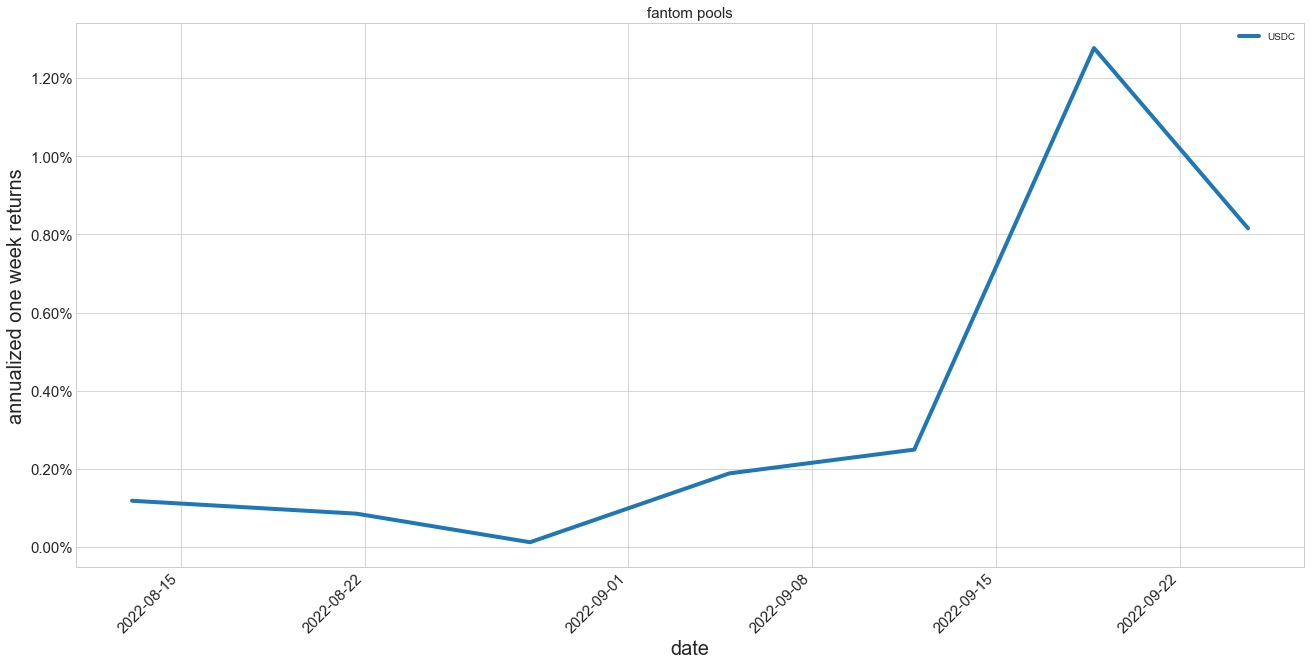

In [22]:
# fantom Pools
chart_chain = 'fantom'
# basic line chart to see trend of pools
# create series
fig, ax = plt.subplots()
# x_eth = df_lp_token_ma['timestamp'][(df_lp_token_ma['chain']==chart_chain)&(df_lp_token_ma['tokenSymbol']=='ETH')]
# y_eth = df_lp_token_ma['apy'][(df_lp_token_ma['chain']==chart_chain)&(df_lp_token_ma['tokenSymbol']=='ETH')]
x_usdc = df_lp_token_ma['timestamp'][(df_lp_token_ma['chain']==chart_chain)&(df_lp_token_ma['tokenSymbol']=='USDC')]
y_usdc = df_lp_token_ma['apy'][(df_lp_token_ma['chain']==chart_chain)&(df_lp_token_ma['tokenSymbol']=='USDC')]
# x_usdt = df_lp_token_ma['timestamp'][(df_lp_token_ma['chain']==chart_chain)&(df_lp_token_ma['tokenSymbol']=='USDT')]
# y_usdt = df_lp_token_ma['apy'][(df_lp_token_ma['chain']==chart_chain)&(df_lp_token_ma['tokenSymbol']=='USDT')]

# add series
# ax.plot(x_eth, y_eth, linewidth=4.0, label="ETH")
ax.plot(x_usdc, y_usdc, linewidth=4.0, label="USDC")
# ax.plot(x_usdt, y_usdt, linewidth=4.0, label="USDT")

plt.title(f'{chart_chain} pools', loc='center', fontsize=15)
plt.xticks(rotation=45, ha="right", fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('date', fontsize=20)
plt.ylabel('annualized one week returns', fontsize=20)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# width, height
plt.rcParams["figure.figsize"]=(22, 10)
plt.legend(loc='best')

plt.show()

In [23]:
df_lp_token_min_dates

,tokenAddress,timestamp,tokenPriceInLPShares,chain
0,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,2022-03-16 12:42:23,999998335455560320,ethereum
1,0xdac17f958d2ee523a2206206994597c13d831ec7,2022-03-16 13:51:34,999998206915211648,ethereum
2,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,2022-03-16 09:48:51,999974251062770560,ethereum
3,0xf17e65822b568b3903685a7c9f496cf7656cc6c2,2022-03-16 10:31:44,999981293403809152,ethereum
4,0x2791bca1f2de4661ed88a30c99a7a9449aa84174,2022-03-14 22:09:25,999833361106482304,polygon
5,0xc2132d05d31c914a87c6611c10748aeb04b58e8f,2022-03-16 07:11:41,999950661871000576,polygon
6,0x7ceb23fd6bc0add59e62ac25578270cff1b9f619,2022-03-15 21:08:19,999895298921578880,polygon
7,0x91c89a94567980f0e9723b487b0bed586ee96aa7,2022-03-16 07:09:13,999983958391184128,polygon
8,0xa7d7079b0fead91f3e65f86e8915cb59c1a4c664,2022-03-15 19:13:58,999900000000999936,avalanche
9,0x49d5c2bdffac6ce2bfdb6640f4f80f226bc10bab,2022-03-16 12:36:45,999851973462878976,avalanche
